In [1]:
import sys, re, math
sys.path.append('../../tensorflow-model-garden') # Path to Tensorflow model garden installation directory
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pprint as pp
AUTO = tf.data.AUTOTUNE
print("Tensorflow version", tf.__version__)

Tensorflow version 2.4.0


In [2]:
# Tensorflow Model Garden imports
from official.vision.detection.configs import factory as tf_garden_config_factory
from official.modeling.hyperparams import params_dict as tf_garden_params_dict
from official.vision.detection.modeling import factory as tf_garden_model_factory
from official.vision.detection.dataloader import mode_keys as tf_garden_mode_keys
from official.vision.detection.executor.detection_executor import DetectionDistributedExecutor as tf_garden_training_loop

# Some flags are mandatory in Tensorflow Model Garden. This is unfortunate. Use default values for now.
from absl import flags
from official.utils import hyperparams_flags
hyperparams_flags.initialize_common_flags()
flags.FLAGS([""])

%matplotlib inline
# official.vision.detection.executor.detection_executor also imports
# official.vision.detection.utils.object_detection.vusualization_utils.py
# which messes up the matplotlib backend. This magic resets it.

# TPU / GPU detection 

In [3]:
strategy = tf.distribute.get_strategy()

#try: # detect TPUs
#    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#    strategy = tf.distribute.TPUStrategy(tpu)
#    policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
#    tf.keras.mixed_precision.experimental.set_policy(policy)
#except ValueError: # detect GPUs or multi-GPU machines
#    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Configuration

In [4]:
DATA_PATH_PATTERN = 'gs://practical-ml-vision-book/arthropod_detection_tfr/size_1024x724/*.tfrec'

BATCH_SIZE = 32 * strategy.num_replicas_in_sync

MODEL_DIR = 'gs://ml1-demo-martin/arthropod_jobs'

RAW_CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera',
               '_truncated', '_blurred', '_occluded', ]
CLASSES = [klass for klass in RAW_CLASSES if klass not in ['_truncated', '_blurred', '_occluded']]

PAD_MAX_BOXES = 50

# Lepidoptera = butterfies and moths
# Hymenoptera = wasps, bees and ants
# Hemiptera = true bugs (cicadas, aphids, shield bugs, ...)
# Odonata = dragonflies
# Diptera = fies
# Araneae = spiders
# Coleoptera = beetles

# NOT IN DATASET
# Orthoptera = grasshoppers

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

TRAIN_FILENAMES = tf.io.gfile.glob(DATA_PATH_PATTERN)
print(f"Found {len(TRAIN_FILENAMES)} TFRecord files.")
NB_TRAIN_IMAGES = count_data_items(TRAIN_FILENAMES)
print(f"{NB_TRAIN_IMAGES} images")

Found 32 TFRecord files.
15376 images


# Visualization utilities

In [5]:
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

def display_detections(images, offsets, resizes, detections, classnames, ground_truth_boxes=[]):
    # scale and offset the detected boxes back to original image coordinates
    boxes   = [[ (x,y,w,h)  for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    boxes   = [[ (x-ofs[1], y-ofs[0], w, h) for x,y,w,h in boxlist ] for boxlist, ofs in zip(boxes, offsets)]
    boxes   = [[ (x*rsz, y*rsz, w*rsz, h*rsz) for x,y,w,h in boxlist ] for boxlist, rsz in zip(boxes, resizes)]
    classes = [[ int(klass) for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    scores  = [[ score      for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes)
    
    
# images, boxes and classes must have the same number of elements
# scores can be en empty list []. If it is not empty, it must also
# have the same number of elements.
# classnames is the list of possible classes (strings)
def display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes=[]):
    N = len(images)
    sqrtN = int(math.ceil(math.sqrt(N)))
    aspect = sum([im.shape[1]/im.shape[0] for im in images])/len(images) # mean aspect ratio of images
    fig = plt.figure(figsize=(15,15/aspect), frameon=False)
    
    for k in range(N):
        ax = plt.subplot(sqrtN, sqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])
        
        if ground_truth_boxes:
            for box in ground_truth_boxes[k]:
                x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
                #x, y, w, h = (box[0], box[1], box[2], box[3])
                rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#FFFFFFA0',facecolor='none')
                ax.add_patch(rect)

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
            x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
            #x, y, w, h = (box[0], box[1], box[2], box[3])
            #label = classnames[klass-1] # predicted classes are 1-based
            label = classnames[klass]
            if scores:
                label += ' ' + str(int(scores[k][i]*100)) + '%' 
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#00000080',facecolor='none')
            ax.add_patch(rect)
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=2,edgecolor='#FFFF00FF',facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#00000080', fc='#0000004E', linewidth=3) )
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#FFFF00FF', fc='#0000004E', linewidth=1.5) )
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

# Dataset

In [6]:
def read_tfrecord(example):
    feature = {
        "image": tf.io.FixedLenFeature([], tf.string), # compressed image bytes
        "name": tf.io.FixedLenFeature([], tf.string),  # string
        "boxes": tf.io.VarLenFeature(tf.int64),        # bounding boxes, all coordinates flattened
        "nb_tags": tf.io.VarLenFeature(tf.int64),      # nb of tags per box
        "tags": tf.io.VarLenFeature(tf.string)         # flat list of tags
    }
    example = tf.io.parse_single_example(example, feature)
    name = example['name']
    image = tf.image.decode_jpeg(example['image'], channels=3)
    boxes = tf.sparse.to_dense(example['boxes'])
    boxes = tf.reshape(boxes, [-1, 4])
    nb_tags = tf.sparse.to_dense(example['nb_tags'])
    flat_tags = tf.sparse.to_dense(example['tags'])
    tags = tf.RaggedTensor.from_row_lengths(flat_tags, nb_tags)
    
    # Test: data processing should work for images with no boxes
    #boxes,tags = tf.cond(tf.random.uniform([])<0.5,
    #        lambda: (boxes[0:0], tags[0:0]),
    #        lambda: (boxes, tags),
    #       )
    
    return image, name, boxes, tags

def keep_one_tag_per_box(tags):
    # Keeping first tag only. Other tags are not bug names but qualifiesrs like '_truncated', '_blurred', '_occluded'
    # Input: one tag list per box: ex: [['Odonata', '_blurred'], ['Hymenoptera']] for 2 boxes
    # This works for 0 boxes (tested)
    tags = tags[:, 0:1] # Cannot index into ragged dimension, must do this.
    tags = tags.merge_dims(-2,-1) # equivalent to tf.squeeze(tags, axis=-1) for ragged tensor
    return tags

def pad_to_max(x, max_n):
    pad_n = tf.maximum(max_n-len(x), 0)
    # padding are pairs of [before, after] nb paddings for each dimension
    padding0 = tf.convert_to_tensor([[0, pad_n]])
    paddings = tf.zeros([tf.rank(x)-1, 2], dtype=tf.int32)
    paddings = tf.concat([padding0, paddings], axis=0)
    return tf.pad(x, paddings)

def lookup_tags(tags, class_table):
    classes = class_table.lookup(tags)
    return classes
    
def load_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    
    numerical_classes = [i for i in range(len(CLASSES))]
    class_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(CLASSES, numerical_classes), default_value=-1)
        
    dataset = dataset.map(lambda x,y,z,tags: (x,y,z,keep_one_tag_per_box(tags)))
    dataset = dataset.map(lambda x,y,z,tags: (x,y,z,tags, lookup_tags(tags, class_table)))
    return dataset

def get_dataset_for_visualization(batch_size):
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(batch_size))
    return dataset

def pad_everything(image, name, boxes, tags, classes):
    nb_boxes = len(boxes)
    boxes = pad_to_max(boxes, PAD_MAX_BOXES)
    tags = pad_to_max(tags, PAD_MAX_BOXES)
    classes = pad_to_max(classes, PAD_MAX_BOXES)
    return image, name, boxes, tags, classes, nb_boxes
    
def get_training_dataset(batch_size=BATCH_SIZE):
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.map(pad_everything)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size) # if batching fails, increase PAD_MAX_BOXES
    dataset = dataset.prefetch(AUTO)
    return dataset

In [7]:
dataset_visualization_iterator = iter(get_dataset_for_visualization(batch_size=4))

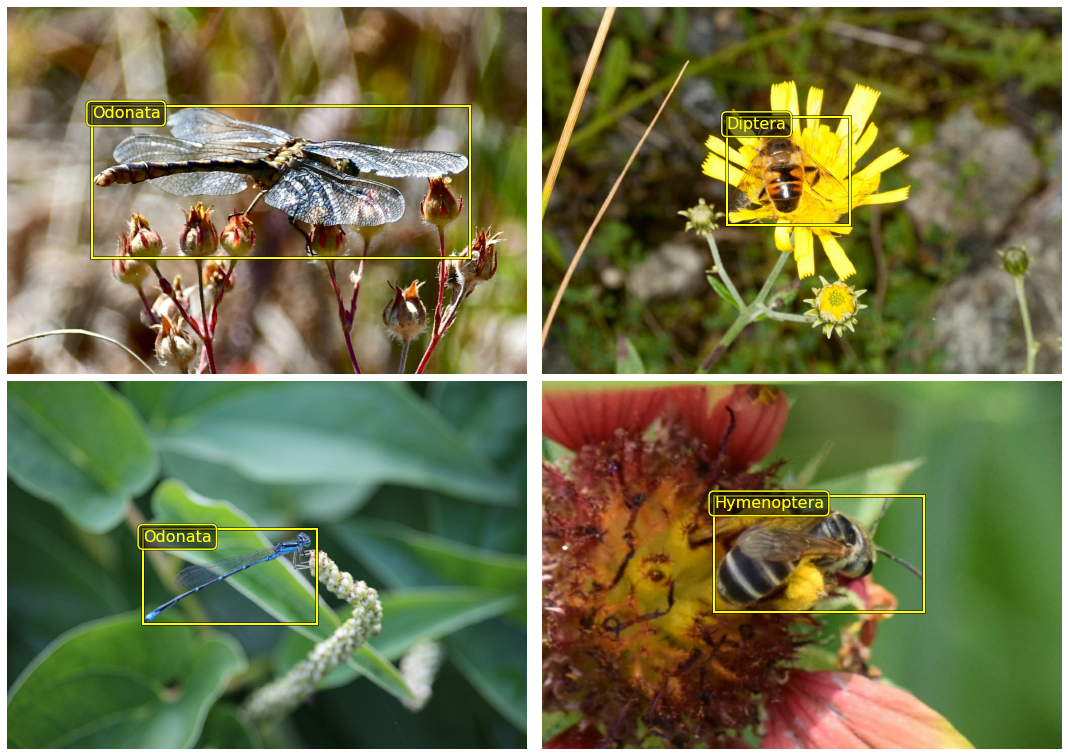

In [8]:
# run this cell multiple times to see more images
image, name, boxes, tags, classes = next(dataset_visualization_iterator)
#classes = [[CLASSES.index(taglist[0]) for taglist in batchitem] for batchitem in tags]
display_with_boxes(image.numpy(), boxes, classes, None, CLASSES, ground_truth_boxes=[])

# Model

In [9]:
params = tf_garden_config_factory.config_generator('retinanet')
params_override = { 'architecture': {'backbone': 'spinenet',
                                     'multilevel_features': 'identity',
                                     'num_classes': 7},
                    'spinenet': {'model_id': '49'}
                  }
params = tf_garden_params_dict.override_params_dict(params, params_override, is_strict=True)
#pp.pprint(params.as_dict())

In [10]:
model_builder = tf_garden_model_factory.model_generator(params)

def create_model(params):
    model = model_builder.build_model(params, mode=tf_garden_mode_keys.TRAIN)
    return model

# Training

In [11]:
num_workers = int(strategy.num_replicas_in_sync + 7) // 8
is_multi_host = (int(num_workers) >= 2)

trainig_loop = tf_garden_training_loop(
        strategy=strategy,
        params=params,
        model_fn=create_model,
        loss_fn=model_builder.build_loss_fn,
        is_multi_host=is_multi_host,
        #predict_post_process_fn=model_builder.post_processing,
        #trainable_variables_filter=model_builder.make_filter_trainable_variables_fn()
    )

# TODO: understand this...
# in multihost mode, dataset.distribute_from_function is used instead of dataset.distribute
#if is_multi_host:
#      train_input_fn = functools.partial(
#          train_input_fn,
#          batch_size=params.train.batch_size // strategy.num_replicas_in_sync)

# TODO: figure out outside automatic compilation for Tensorboard summaries on TPU

In [12]:
result = trainig_loop.train(
    train_input_fn=get_training_dataset,
    model_dir=MODEL_DIR,
    iterations_per_loop=100,
    total_steps=NB_TRAIN_IMAGES//BATCH_SIZE,
    #init_checkpoint=model_builder.make_restore_checkpoint_fn(),
    save_config=True)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
ERROR:absl:Detection: train metric is not an instance of tf.keras.metrics.Metric.


ValueError: in user code:

    ../../tensorflow-model-garden/official/modeling/training/distributed_executor.py:289 train_step  *
        per_replica_losses = strategy.run(replicated_step, args=(next(iterator),))
    ../../tensorflow-model-garden/official/vision/detection/executor/detection_executor.py:76 _replicated_step  *
        inputs, labels = inputs

    ValueError: too many values to unpack (expected 2)
